# Reproduction of the paper [Visualizing and understanding RNNs](https://arxiv.org/abs/1506.02078)
Project for the subject [344.063 Special Topics Natural Language Processing with Deep Learning ](https://kusss.jku.at/kusss/sz-lvadetail-overview.action?courseId=344063%2C2020S)

Authors: M. Vogl, F. Shalaby

Limitation: We only worked with 3mb warandpeace.txt, as the linux kernel dataset grew from 400mb during the writing of the paper to 800mb, which wouldn't fit into my GPU as a one-hot-able LongTensor.

Training for the 3x4x6 grid (with early stopping and parameters seen in config.txt) for 3mb warandpeace.txt took ~4h on a GTX2070Super.

**Improvements to other implementations**
* Using pytorch and lightning instead of lua-torch unlike the [original kapathy charrnn](https://github.com/karpathy/char-rnn)
* Still working with a current pytorch version unlike the great [huango implementation](https://github.com/huanghao-code/VisRNN_ICLR_2016_Text) 
* Shoter code - easier to understand: Old implementation. 1500+ LOC. New: 400 LOC (Counted with <br>`projects find proj -name "*.py" -print -exec cat {} \; | wc -l`)
* This version is extending the torch builtin [LSTM](https://pytorch.org/docs/master/generated/torch.nn.LSTM.html)/[GRU](https://pytorch.org/docs/master/generated/torch.nn.GRU.html)/[RNN](https://pytorch.org/docs/master/generated/torch.nn.RNN.html) with activation gate extraction, which is 10-100x faster than the other implementations. Includes support for apex 16 bit precision, cuda and optimized dataloading.

This file assumes you have downloaded the models (too big for github) from [http://öä.eu/models.zip](http://öä.eu/models.zip).

Hyperparameters from config:

In [1]:
print(open("config.py").read())  # hyperparameters used

import torch

# linux = https://cs.stanford.edu/people/karpathy/char-rnn/
_FILE_NAMES = ["warandpeace", "shakespeare"]
FILE_NAME = _FILE_NAMES[0]
FILE_PATH = f"data/{FILE_NAME}.txt"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
N_LAYERS = 3
SEQ_LEN = 70
HIDDEN_SIZE = 32
BATCH_SIZE = 128
PREDICT_SEQ_LEN = SEQ_LEN
LR = 0.01
CLIP = 5
DROPOUT = 0.0
MAX_EPOCHS = 100
EMBEDDING_DIM = 0  # 0 = one-hot encoding
MODEL_NAME = "lstm"
PRECISION = 32  # 16 if DEVICE == "cuda" else 32
SPLITS = (0, 90, 95, 100)



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, IFrame
from matplotlib_venn import venn3

import dataloader
from config import *
from visualize import visualize_gate, visualize_cell
from net.charrnn import CharRNN
%matplotlib inline

(trl, tel, val), vocab = dataloader.load(FILE_PATH, DEVICE, SPLITS, BATCH_SIZE, SEQ_LEN, unique=True)

# Text generation

In [3]:
net = CharRNN.load_from_file("rnn", 1, 32).eval()
for method in "rand", "max", "softrand":
    print(method, net.predict("Hello ", PREDICT_SEQ_LEN, vocab, method=method), sep="\t")

/usr/lib/python3.8/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'net.charrnn.CharRNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/lib/python3.8/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'net.rnnx.RNNx' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


rand	Hello !yHxxQ?O?viEGKECB:7OfMVOSNQ()4B*vYHMMMK)fJVg)RA7oAYO*giGPwM6L;x9RHxJ=g
max	Hello the said her and the said her and the said her and the said her and th
softrand	Hello ghens the ce rrasha rracke's. his by ce whot sicce of thestood reary a


# Model accuracy comparison via venn diagram

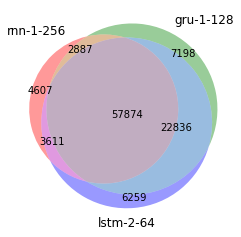

In [4]:
sets = {}
for params in [("rnn", 1, 256), ("gru", 1, 128), ("lstm", 2, 64)]:
    net = CharRNN.load_from_file(*params).eval()
    val = set()
    offset = 0
    for x, y in tel:
        correct = net.forward(x).argmax(-1) == y.flatten()
        val |= {n + offset for n, b in enumerate(correct) if b}
        offset += len(y.flatten())
    sets[net.name()] = val
venn3(sets.values(), sets.keys())
plt.show()

# Model performance table - Training | Test - Loss | Accuracy

In [ ]:
model_names = ["lstm", "rnn", "gru"]
n_layers = [1, 2, 3, 4]
hidden_sizes = [32, 64, 128, 256, 512, 1024]

for loader, loadername in (trl, "train data"), (tel, "test data"):
    corrects, losses = [], []
    display(loadername)
    for MODEL_NAME in model_names:
        for N_LAYERS in n_layers:
            for HIDDEN_SIZE in hidden_sizes:
                net = CharRNN.load_from_file(MODEL_NAME, N_LAYERS, HIDDEN_SIZE).eval()
                correct, loss = [], []
                for x, y in loader:
                    out = net.forward(x)
                    correct += (out.argmax(-1) == y.flatten()).tolist()
                    loss += [(torch.nn.functional.cross_entropy(out, y.flatten())).tolist()]
                corrects.append(np.mean(correct))
                losses.append(np.mean(loss))

    for title, arr in (("accuracy", corrects), ("loss", losses)):
        arr = np.array(arr).reshape((len(hidden_sizes), len(model_names) * len(n_layers)))
        columns = pd.MultiIndex.from_product([model_names, n_layers])
        df = pd.DataFrame(arr, columns=columns, index=hidden_sizes)
        df.columns.name = title
        display(df.round(3))

'train data'

# Gate Visualization (test set)

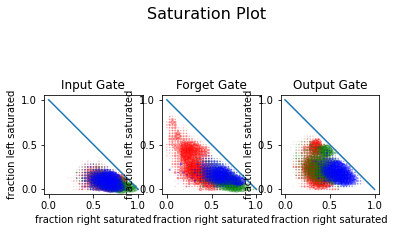

In [2]:
net = CharRNN.load_from_file("lstm", N_LAYERS, HIDDEN_SIZE).eval()
input_gates, forget_gates, cell_gates, output_gates, cell_states = net.extract_from_loader(tel)
visualize_gate(input_gates, forget_gates, output_gates)

# Cell visualization (test set)

In [2]:
net = CharRNN.load_from_file("gru", N_LAYERS, HIDDEN_SIZE).eval()
reset_gates, update_gates = net.extract_from_loader(tel)
visualize_cell(reset_gates[:, 50:1000], dataloader.decode(tel.dataset.data[50:1000], vocab))

/usr/lib/python3.8/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'net.charrnn.CharRNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


# Showcase of the rnn cell visualization